In [1]:
## anaconda3 (Python 3.9.13) Kernel

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# pair trade packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# Load Pairs Data


In [2]:
def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')

# Load the dictionary from the pickle file
with open('pairsOutcome.pkl', 'rb') as file:
    pairsOutcome = pickle.load(file)

print("Dictionary loaded from pairsOutcome.pkl")


# Load stock data and get return 
tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)
tpxData = tpxData.dropna(axis='columns')
return_df = (tpxData / tpxData.shift(1)) - 1

Dictionary loaded from pairsOutcome.pkl


In [3]:
len(pairsOutcome)

508

# Get Pair Trade Portfolio
`pairsOutcome` already have TOPIX stocks with highest liquidity and are tested for stationarity over a 1 year window

Choose top 10 known pair trades by returns in the total dataset

In [4]:
# Sort the keys by their cumpnl[-2] values in descending order
top_keys = sorted(
    pairsOutcome,
    key=lambda k: pairsOutcome[k].cumpnl.iloc[-2],  # Access cumpnl[-2] safely
    reverse=True
)[:10]  # Get the top 10 keys

# Print the top 10 performing trades
print("Top 10 performing trades:")
for i, key in enumerate(top_keys, 1):
    print(f"{i}. Key: {key}, Value: {pairsOutcome[key].cumpnl.iloc[-2]}")

Top 10 performing trades:
1. Key: 1801 JP Equity 2670 JP Equity, Value: 2.5797887367591246
2. Key: 3778 JP Equity 6701 JP Equity, Value: 2.537242032391529
3. Key: 2760 JP Equity 6254 JP Equity, Value: 2.3688208386917404
4. Key: 5706 JP Equity 6954 JP Equity, Value: 2.2676474298290237
5. Key: 7951 JP Equity 9684 JP Equity, Value: 2.0657325467200596
6. Key: 1808 JP Equity 6481 JP Equity, Value: 1.9929348941248262
7. Key: 3099 JP Equity 5831 JP Equity, Value: 1.939742664925484
8. Key: 1808 JP Equity 6971 JP Equity, Value: 1.9132602773493155
9. Key: 4021 JP Equity 9843 JP Equity, Value: 1.8675031161000868
10. Key: 5929 JP Equity 6504 JP Equity, Value: 1.811533049967201


## Calculate baseline Pair Trade Portfolio Returns

Assume that each pair  and there is no diversification of returns. Each Pair Trade is self-funded and only has risk of 10% of initial investment (1 unit).

2013 is used as warm up year to consolidate rolling window aggregate mid and Std dev data. Investment only starts from 2014.

In [5]:
dailypnl_data = [pairsOutcome[key]['dailypnl'] for key in top_keys]

df_daily_returns =  pd.DataFrame(dailypnl_data).T # Transpose to align rows
df_daily_returns.cumsum()

,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl
Date,,,,,,,,,,
1/1/2013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2/1/2013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3/1/2013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4/1/2013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7/1/2013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
27/5/2024,2.552379,2.537242,2.368821,2.286593,2.065733,1.992935,1.939743,1.925137,1.871367,1.815232
28/5/2024,2.552379,2.537242,2.368821,2.283212,2.065733,1.992935,1.939743,1.925137,1.913829,1.839758
29/5/2024,2.579789,2.537242,2.368821,2.279302,2.065733,1.992935,1.939743,1.915545,1.874071,1.828446


In [6]:
ten_portf_return = np.exp(df_daily_returns.cumsum().iloc[-2]).sum()/10
f"From 1 Jan 2014 investing 1 unit resulted in 31 May 2024 return {ten_portf_return:.2f} unit"

'From 1 Jan 2014 investing 1 unit resulted in 31 May 2024 return 8.77 unit'

In [7]:
f"Baseline Annual return is {(np.log(ten_portf_return))/10.5*100:.2f}%"

'Baseline Annual return is 20.68%'

## Baseline graph

Investing starts from 2014 as a warm start for 1 year rolling window (from 2013) we plot the total returns.

In [8]:
df_port_return = df_daily_returns.cumsum().sum(axis=1)/10
np.exp(df_port_return).describe()

count    2979.000000
mean        3.293014
std         2.025303
min         0.992520
25%         1.471005
50%         2.709412
75%         5.106194
max         8.515421
dtype: float64

Text(0.5, 1.0, 'Baseline returns')

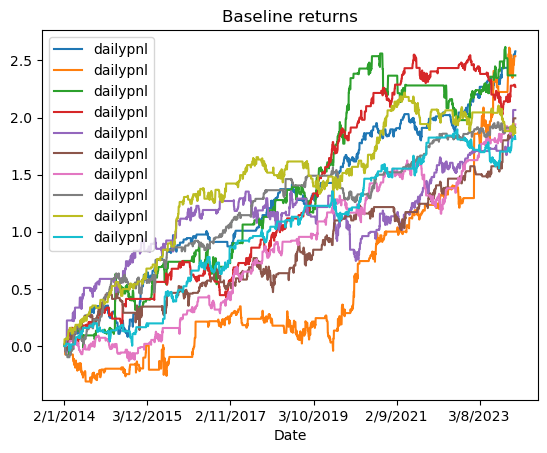

In [9]:
df_daily_returns.cumsum()[262:-1].plot()
plt.title("Baseline returns")

In [10]:
postion_data = [pairsOutcome[key]['position'] for key in top_keys]

pd.DataFrame(postion_data).T.abs().sum(axis=1).describe()

count    2979.000000
mean        3.288352
std         1.794075
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         9.000000
dtype: float64

# Machine Learning Challenge

## Background
Initial evaluation of the baseline portfolio shows that draw downs are small. Originally team had the idea of using Machine Learning to optimise for sizing of these pair trades. However since there was no significant drawdowns the returns are linearly increasing with investment sizing i.e. greater nominal investment in the the pair trade the proportionate increase in returns without realising significant drawdown risk.

Instead of optimising for sizing, we can explore Machine Learning in terms of strategy on this stationary dataset. Whereas our prescribed strategy is to enter at +/- 1 std dev, exit at 0 with +/- 2 std dev stop loss. These are only suggestions and arbitrary levels.

With Machine Learning, we can discover if it will uncover the mean reverting nature and recommend another threshhold. We use Q Learner to understand state space with the same spread, mid, std dev parameters as the baseline.

### Steps
#### Environment:
- State Space: A set of all possible states the agent can be in.  
  - [spread, mid, 2 sd low, 1 sd low, 1 sd high, 2 sd high]
- Action Space: A set of all possible actions the agent can take in each state.   
  - [-1, # short\
      0, # uninvested\
      1  # long]   
- Reward Function: A function that assigns a numerical reward to each state-action pair, indicating the immediate consequence of taking a particular action in a specific state.
  - dailypnl
- Transition Function: A function that determines the probability of transitioning from one state to another when a particular action is taken.
  - deterministic based on historical performance
#### Agent:

- Q-Table: A matrix that stores the estimated Q-values for each state-action pair. Q-values represent the expected future reward for taking a specific action in a given state.   
  - continuous Q table?
- Learning Rate (α): A parameter that controls how much the Q-values are updated with each new experience.   
- Discount Factor (γ): A parameter that determines the importance of future rewards. A higher discount factor gives more weight to future rewards.   
- Exploration Rate (ε): A parameter that controls the balance between exploration (trying new actions) and exploitation (choosing the action with the highest Q-value).   
- Q-Learning Algorithm:

  - Initialization: Initialize the Q-table with random values or zeros.   
  - Exploration and Exploitation: Use an exploration strategy (e.g., ε-greedy) to choose an action:
    - With probability ε, choose a random action.   
    - With probability 1-ε, choose the action with the highest Q-value for the current state.   
  
  - Take Action: Execute the chosen action in the environment.   
  - Observe Reward and Next State: Observe the immediate reward and the next state resulting from the action.
- Update Q-Value: Update the Q-value of the current state-action pair using the following formula:

#### Training and Test set

2013 is used for warm start\
2014 - 2023 train data since NN need a lot of training data\
2024 onwards (5 months) test data


In [11]:
## Get pair stock data
def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')
valid = pd.read_csv('validPairs4.csv', 
                    index_col=0, 
                    parse_dates=True, 
                    date_parser=custom_date_parser)
## get list of pair stocks
validPairsList = [
    [item.strip() + ' Equity' for item in pair.split('Equity') if item.strip()]
    for pair in top_keys
]

In [12]:
rollingWindow = 262
cutLossSd = 2

In [ ]:
for pair in validPairsList:
    df = pd.DataFrame()

    #Calculate Standard Deviations
    df['spread'] = valid[f'spread_{pair[0]}_{pair[1]}']
    df['mid'] =  df['spread'].rolling(rollingWindow).mean()
    df['1sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std()
    df['1sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std()
    df['2sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['2sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['position'] = 0

    df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high']), 'position'] = -1
    df.loc[(df['spread']< df['1sd low']) & (df['spread'] > df['2sd low']), 'position'] = 1

    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position']*return_df[f'{pair[1]}'].shift(-1) + df[f'{pair[0]} position']*return_df[f'{pair[0]}'].shift(-1)
    df['cumpnl'] = df['dailypnl'].cumsum()

    pairsOutcome[f'{pair[0]} {pair[1]}'] = df

In [23]:
-1*return_df[f'{pair[0]}'].iloc[1000+1] + 1*return_df[f'{pair[1]}'].iloc[1000+1]

0.004531039271575721

In [28]:
return_df[f'{pair[0]}'].iloc[1000+1], return_df[f'{pair[0]}'].shift(-1).iloc[1000]

(-0.013994910941475869, -0.013994910941475869)

In [25]:
return_df[f'{pair[0]}'].iloc[999:1002]

Date
2016-10-31    0.000000
2016-11-01   -0.002538
2016-11-02   -0.013995
Name: 1801 JP Equity, dtype: float64

In [14]:
validPairsList

[['1801 JP Equity', '2670 JP Equity'],
 ['3778 JP Equity', '6701 JP Equity'],
 ['2760 JP Equity', '6254 JP Equity'],
 ['5706 JP Equity', '6954 JP Equity'],
 ['7951 JP Equity', '9684 JP Equity'],
 ['1808 JP Equity', '6481 JP Equity'],
 ['3099 JP Equity', '5831 JP Equity'],
 ['1808 JP Equity', '6971 JP Equity'],
 ['4021 JP Equity', '9843 JP Equity'],
 ['5929 JP Equity', '6504 JP Equity']]

In [15]:
dailypnl_data = [pairsOutcome[key]['dailypnl'] for key in top_keys]

df_daily_returns =  pd.DataFrame(dailypnl_data).T # Transpose to align rows
df_daily_returns.cumsum()

,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl,dailypnl
Date,,,,,,,,,,
2013-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2024-05-27,2.552379,2.537242,2.368821,2.286593,2.065733,1.992935,1.939743,1.925137,1.871367,1.815232
2024-05-28,2.552379,2.537242,2.368821,2.283212,2.065733,1.992935,1.939743,1.925137,1.913829,1.839758
2024-05-29,2.579789,2.537242,2.368821,2.279302,2.065733,1.992935,1.939743,1.915545,1.874071,1.828446


In [16]:
pairsOutcome[top_keys[0]].index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10',
               '2013-01-11', '2013-01-14',
               ...
               '2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23',
               '2024-05-24', '2024-05-27', '2024-05-28', '2024-05-29',
               '2024-05-30', '2024-05-31'],
              dtype='datetime64[ns]', name='Date', length=2979, freq=None)